<a href="https://colab.research.google.com/github/rajibmondal/BERT-Fine-Tuning-with-PyTorch-for-Sentence-classification/blob/master/BERT_fine_tuning_with_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))


Found GPU at: /device:GPU:0


In [0]:
!pip install pytorch-pretrained-bert pytorch-nlp


In [0]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline


In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)


'Tesla K80'

In [0]:
# Upload the train file from your local drive
from google.colab import files
uploaded = files.upload()


Saving in_domain_train.tsv to in_domain_train (1).tsv


In [0]:
df = pd.read_csv("in_domain_train.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])


In [0]:
df.shape

(8551, 4)

In [0]:
df.sample(10)

,sentence_source,label,label_notes,sentence
4996,ks08,1,NaN,John is tough to persuade.
4969,ks08,1,NaN,Did John wonder who would win the game?
4717,ks08,1,NaN,The matter was paid a lot of attention to.
4526,ks08,0,*,"They can't do it, can't they?"
1219,r-67,1,NaN,The sheriff denied that gangsters had bribed him.
1151,r-67,0,?*,We elected the man who he had brought with him...
5544,b_73,0,*,I'm as sad as angry.
7288,sks13,1,NaN,Mary should buy some flowers for her mother to...
5650,c_13,1,NaN,Sincerity is an important quality.
646,bc01,1,NaN,Dry the baby with the cloth asleep.


In [0]:
#create a sentence and lebel lists
sentences = df.sentence.values
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values


In [0]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sente) for sente in sentences]
print('tokenizer the first sentence:',tokenized_texts[0])



tokenizer the first sentence: ['[CLS]', 'our', 'friends', 'won', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.', '[SEP]']


In [0]:
# Set the maximum sequence length. The longest sequence in our training set is 47, but we'll leave room on the end anyway. 
# In the original paper, the authors used a length of 512.
MAX_LEN = 128

In [0]:
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids_without_padding = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

In [0]:
#pad our input tokens
input_ids = pad_sequences(input_ids_without_padding, maxlen = MAX_LEN, dtype='long', truncating='post', padding='post')
input_ids.shape

(8551, 128)

In [0]:
#create attention masks
attention_masks = []

#Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [0]:
# Use train_test_split to split our data into train and validation sets for training
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=123, test_size=0.1)

train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids, random_state = 123, test_size=0.1)

In [0]:
print('train_inputs:',train_inputs.shape)
print('validation_inputs:',validation_inputs.shape)
print('train_labels:',train_labels.shape)
print('validation_labels:',validation_labels.shape)
#print('train_masks:',train_masks.shape)
#print('validation_masks:',validation_masks.shape)

train_inputs: (7695, 128)
validation_inputs: (856, 128)
train_labels: (7695,)
validation_labels: (856,)


In [0]:
#convert all our data into torch tensors
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)


In [0]:
print('train_inputs:',train_inputs.shape)
print('validation_inputs:',validation_inputs.shape)
print('train_labels:',train_labels.shape)
print('validation_labels:',validation_labels.shape)
print('train_masks:',train_masks.shape)
print('validation_masks:',validation_masks.shape)

train_inputs: torch.Size([7695, 128])
validation_inputs: torch.Size([856, 128])
train_labels: torch.Size([7695])
validation_labels: torch.Size([856])
train_masks: torch.Size([7695, 128])
validation_masks: torch.Size([856, 128])


In [0]:
#select the batch size for training For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
batch_size = 32

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memor

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = RandomSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


###Train Model

In [0]:
#Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

In [0]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [{'params':[p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
 'weight_decay_rate':0.01},
{'params':[p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
 'weight_decay_rate':0.00}]

In [0]:
# This variable contains all of the hyperparemeter information our training loop needs

optimizer = BertAdam(optimizer_grouped_parameters, lr=2e-5, warmup=.1)

t_total value of -1 results in schedule not being applied


In [0]:
#Function to calculate the accuracy of our predictions vs lebel

def flat_accuracy(preds, labels):
  pred_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()
  return np.sum(pred_flat == labels_flat)/len(labels_flat)

In [0]:
#store our losses an accuracy for plotting
train_loss_set = []
#number of training epochs
epochs = 4

#trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  
  
  #Training

  #set our model to training mode(as opposesd to evaluation mode)
  model.train()

  #Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0,0


  #train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    #add batch to gpu
    batch = tuple(t.to(device) for t in batch)
    #unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    #clear out the gradients(by default they accumalate)
    optimizer.zero_grad()
    
    #Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask = b_input_mask, labels=b_labels)
    train_loss_set.append(loss.item())
    
    #Backward pass
    loss.backward()
    
    #update parametersnand take a step using the computed gradient
    optimizer.step()
    
    #Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1
    
  print("Train loss:{}".format(tr_loss/nb_tr_steps))
  
  
  
  
  
  #validation

  #put our model to evaluation mode to evaluate loss on the validation
  model.eval()

  #Tracking variables
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0,0


  #train the data for one epoch
  for batch in validation_dataloader:
    #add batch to gpu
    batch = tuple(t.to(device) for t in batch)
    #unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    ##telling the model not to compute or store gradients
    with torch.no_grad():
      
      #Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask = b_input_mask)
    
    #Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    tmp_eval_accuracy = flat_accuracy(logits,label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1
  

  print("validation Accuracy:{}".format(eval_accuracy/nb_eval_steps))
    

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss:0.5339901583915937


Epoch:  25%|██▌       | 1/4 [07:11<21:35, 431.85s/it]

validation Accuracy:0.8252314814814815
Train loss:0.28652105811139156


Epoch:  50%|█████     | 2/4 [14:23<14:23, 431.87s/it]

validation Accuracy:0.8483796296296297
Train loss:0.13971047316776616


Epoch:  75%|███████▌  | 3/4 [21:34<07:11, 431.63s/it]

validation Accuracy:0.8506944444444444
Train loss:0.07359238270197738


Epoch: 100%|██████████| 4/4 [28:46<00:00, 431.65s/it]

validation Accuracy:0.8333333333333334


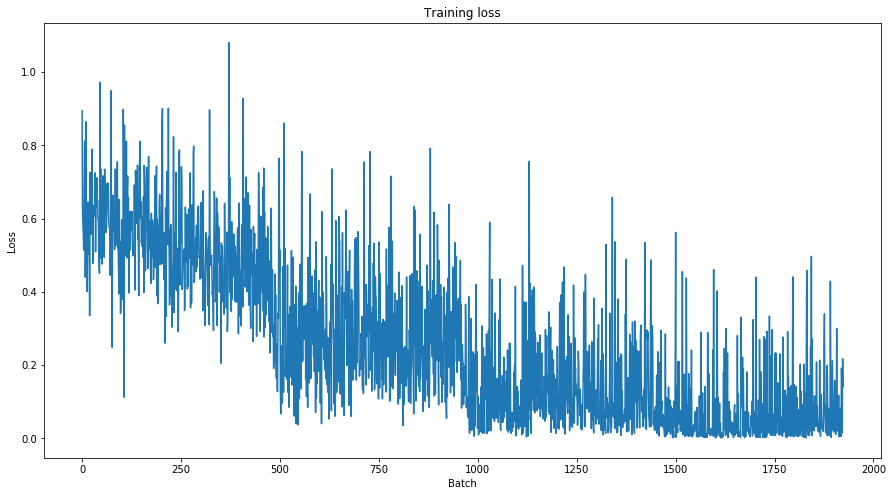

In [0]:
plt.figure(figsize=(15,8))
plt.title('Training loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.plot(train_loss_set)
plt.show()

In [0]:
#Uplod the taste file from the local drive
from google.colab import files
uploaded = files.upload()

Saving out_of_domain_dev.tsv to out_of_domain_dev (1).tsv


In [0]:
df = pd.read_csv("out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source','label','label_notes','sentence'])

#Create sentence and label lists
sentences = df.sentence.values

#We need to add special tokens at the begining and end of the each sentence
sentences = ["[CLS] " + sentence + "[SEP] " for sentence in sentences]
labels = df.label.values

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]


MAX_LEN = 128
#Use bert tokenizer to convert token into their own vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
#pad our input token
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding='post')
#Create attention masks
attention_masks = []

#Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 
  
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)

batch_size = 32

prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)


In [0]:
#Prediction on test set

#put our model to evaluation mode
model.eval()

#Tracking variables
predictions, true_labels = [], []



#Predict
for batch in prediction_dataloader:
  #add batch to gpu
  batch = tuple(t.to(device) for t in batch)
  #unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  ##telling the model not to compute or store gradients
  with torch.no_grad():

    #Forward pass, calculate logit predictions
    logits = model(b_input_ids, token_type_ids=None, attention_mask = b_input_mask)

  #Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  #Store predictions and true lebels
  predictions.append(logits)
  true_labels.append(label_ids)

In [0]:

#import and evaluate each test batch using matthews corelation coefficient
from sklearn.metrics import matthews_corrcoef
matthews_set = []

for i in range(len(true_labels)):
  matthews = matthews_corrcoef(true_labels[i], np.argmax(predictions[i], axis=1).flatten())
  matthews_set.append(matthews)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [0]:
matthews_set

[0.0,
 0.0,
 0.0,
 -0.2277100170213244,
 -0.041344911529736156,
 0.5238095238095238,
 0.38297084310253526,
 -0.2182178902359924,
 0.4879500364742666,
 0.15289415743128767,
 0.49206349206349204,
 0.7453559924999299,
 0.3578300267477955,
 0.7453559924999299,
 0.4472135954999579,
 0.0,
 0.7867957924694432,
 0.5449492609130661,
 0.10087125544480041,
 0.6201736729460423,
 0.021591675854376522,
 0.0,
 0.3333333333333333,
 1.0,
 0.8819171036881969,
 0.6546536707079772,
 0.7867957924694432,
 0.6666666666666666,
 0.28941438070815306,
 -0.021591675854376522,
 0.09759000729485331,
 0.2548235957188128,
 -0.3333333333333333]

In [0]:
# Flatten the predictions and true values for aggregate Matthew's evaluation on the whole dataset
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]


In [0]:
matthews_corrcoef(flat_true_labels, flat_predictions)


0.32764943117295825